In [50]:
import numpy as np
from scipy import optimize
from scipy.stats import linregress
import matplotlib.pyplot as plt

%matplotlib inline

In [51]:
import os
import glob
from collections import defaultdict

import pandas as pd

In [52]:
#Нахожу .log файлы во всех папках Cool_p_N:
collected_data = defaultdict(list)

for f in glob.glob('./Cool_*/log.lammps'):
    print(f)

    pressure = f.split('_')[1]

    with open(f, 'r') as inp:
        for i, line in enumerate(inp):
            if line.startswith('Per MPI rank'):
                startline = i
            if line.startswith('Loop time'):
                endline = i

    df_T_and_density = pd.read_csv(
        f,
        skiprows=startline + 1,
        skipfooter=i - endline + 1,
        sep='\s+',
        engine='python'
    )

    collected_data[pressure].append(df_T_and_density[['Temp', 'Density']])

.\Cool_26000_1\log.lammps
.\Cool_26000_2\log.lammps
.\Cool_26000_3\log.lammps
.\Cool_38000_1\log.lammps
.\Cool_38000_2\log.lammps
.\Cool_38000_3\log.lammps
.\Cool_50000_1\log.lammps
.\Cool_50000_2\log.lammps
.\Cool_50000_3\log.lammps


In [53]:
#Делаю таблицу Температура - Плотность по всем данным для указанного давления:
collected_data['50000'][2]

,Temp,Density
0,598.62231,1.011242
1,603.10185,1.017114
2,599.38540,1.021972
3,598.04668,1.018371
4,588.24348,1.025757
...,...,...
396,205.37828,1.148124
397,203.38073,1.153982
398,200.47763,1.153204
399,202.19981,1.151527


In [54]:
collected_data = {k: pd.concat(df_list, axis=0) for k, df_list in collected_data.items()}

<AxesSubplot:xlabel='Temp', ylabel='Density'>

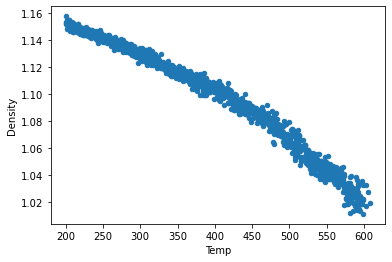

In [55]:
#Рисую график Температура - Плотность по всем точкам для данного давления:
collected_data['50000'].plot.scatter(x='Temp', y='Density', )

In [56]:
#Смотрю, какие давления вообще есть:
for p, T_ro_df in collected_data.items():
    print(p)

26000
38000
50000


In [57]:
#Снова выбираю давление:
df = collected_data['50000']

In [58]:
#Усредняю значения плотности с интервалом 5К по всем данным для выбранного давления:
t_range = 5
averaging_interval = max(1, t_range)

q = int((df['Temp'].max() - df['Temp'].min())/averaging_interval)
df['interval'] = pd.qcut(df['Temp'], q, precision=2)
df['t_interval'] = df['interval'].apply(lambda i: f'{i.mid:.1f}')

averaged_df = df.groupby('t_interval')['Density'].mean().reset_index()
averaged_df['t'] = averaged_df['t_interval'].astype(float)
averaged_df['interval'] = range(1, q+1)

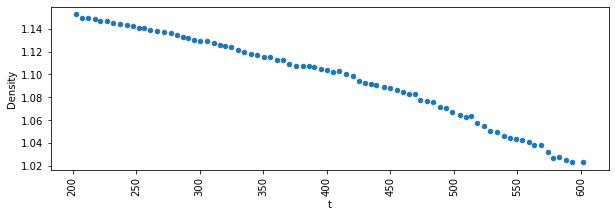

In [59]:
#Рисую график Температура - Плотность по усредненным данным:
averaged_df.plot.scatter(x='t', y='Density', figsize=(10, 3))
_ = plt.xticks(rotation=90)

In [60]:
#Определяю границы будущих линий тренда - беру слева 100К и увеличиваю диапазон, мониторя RMSD. Справа - то же самое, только начиная с 50К, т.к. температура стеклования у нас почти всегда будет с правой стороны графика:
fit_check = {}
N_point_min = 10

best_sum_fit_error = float('inf')
best_split_threshold = (0.0, 0.0)

dts = np.arange(0, 50, averaging_interval)
t_range_min = averaged_df['t'].min()
t_range_max = averaged_df['t'].max()
thresholds = [
    (v1, v2) for v1, v2 in zip(
        dts + t_range_min + 100,
        t_range_max - 50 - dts
    )
]

for left_threshold, right_threshold in thresholds:
    
    if left_threshold > right_threshold:
        print('left_threshold > right_threshold')
        continue

    left_x, left_y = averaged_df[averaged_df['t'] <= left_threshold][['t', 'Density']].values.T
    right_x, right_y = averaged_df[averaged_df['t'] >= right_threshold][['t', 'Density']].values.T

    n_point_left = len(left_x)
    n_point_right = len(right_x)

    if min(n_point_left, n_point_right) < N_point_min:
        print(f'at thresholds ({left_threshold:.1f}, {right_threshold:.1f}) not enough point in one of the split parts: ({n_point_left}, {n_point_right})')
        continue

    left_linefit = linregress(left_x, left_y)
    right_linefit = linregress(right_x, right_y)
    sum_fit_error = left_linefit.stderr + right_linefit.stderr
    if sum_fit_error < best_sum_fit_error:
        best_sum_fit_error = sum_fit_error
        best_split_threshold = (left_threshold, right_threshold)
        left_intercept, left_slope, left_R = left_linefit.intercept, left_linefit.slope, left_linefit.rvalue**2
        right_intercept, right_slope, right_R = right_linefit.intercept, right_linefit.slope, right_linefit.rvalue**2

    fit_check[(left_threshold, right_threshold)] = {'left_linefit.stderr': left_linefit.stderr,
                            'right_linefit.stderr': right_linefit.stderr,
                            'sum_fit_error': sum_fit_error,
                            'n_point_left': n_point_left,
                            'n_point_right': n_point_right,}

best_sum_fit_error: 2.1323574269744658e-05 at threshold: (347.6, 506.9)


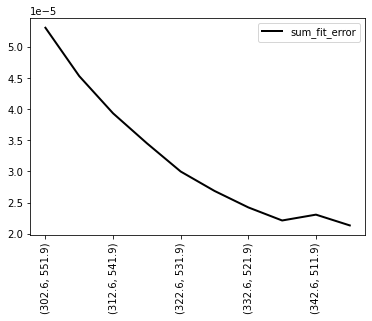

In [61]:
#Рисую RMSD при разных границах линии тренда:
print(f'best_sum_fit_error: {best_sum_fit_error} at threshold: {best_split_threshold}')
pd.DataFrame(fit_check).T.plot(y='sum_fit_error', lw=2, c='k')
_ = plt.xticks(rotation=90)

In [62]:
#Определяю точку пересечения линий тренда - температуру стеклования:
left_intercept, left_slope, left_R

(1.2010196655389738, -0.00023904679355857023, 0.9916401987370136)

In [63]:
right_intercept, right_slope, right_R

(1.2918799695978307, -0.00045191942089293157, 0.9760326231484856)

In [64]:
slope = left_slope - right_slope
inter = right_intercept - left_intercept
Tg = inter/slope
Tg

426.8294387898997

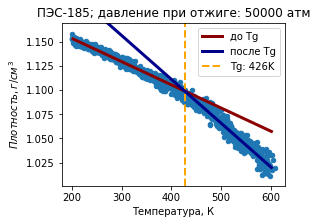

In [66]:
#Рисую график с линиями тренда
df.plot.scatter(x='Temp', y='Density', figsize=(4, 3))
ymin = 0.99*df['Density'].min()
ymax = 1.01*df['Density'].max()

t_range = np.arange(t_range_min, t_range_max, 1)
plt.plot(t_range, left_intercept + left_slope*t_range, 'darkred', label='до Tg', lw=3)
plt.plot(t_range, right_intercept + right_slope*t_range, 'darkblue', label='после Tg', lw=3)
plt.ylim(ymin, ymax)
plt.vlines(Tg, ymin, ymax, colors='orange', linestyles='--', label=f'Tg: {int(Tg)}K', lw=2)
plt.title('ПЭС-185; давление при отжиге: 50000 атм')
plt.xlabel('Температура, К')
plt.ylabel('$Плотность, г/см^3$')
plt.legend()